In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import folium
import json
from sklearn.cluster import DBSCAN

In [11]:
date_columns = ['property_scraped_at', 'host_since', 'reviews_first', 'reviews_last']
train_df = pd.read_csv("train.csv", parse_dates=date_columns)
#train_df.dropna(subset=['property_zipcode'], inplace=True)
train_df = train_df[(train_df.property_zipcode.str.len() == 4)]
train_df['property_zipcode'] = train_df['property_zipcode'].astype(int)
train_df = train_df[train_df.target < 385]

In [12]:
with open("belgium_2.geojson", encoding='utf-8', errors='ignore') as json_data:
     belgium_geocode = json.load(json_data, strict=False)

import requests
my_link = "https://www.mapsofworld.com/postal-codes/belgium/vlaanderen/antwerpen.html"

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}

r = requests.get(my_link, headers=header)

df_xyz = pd.read_html(r.text)
antwerp_zipcodes = pd.DataFrame(df_xyz[2].iloc[1:].values, columns = df_xyz[2].iloc[0].values)
antwerp_zipcodes['Zipcode'] = antwerp_zipcodes['Zipcode'].astype(int)

In [13]:
train_df['target'] = np.log2(train_df.target)

In [14]:
antwerp_df = train_df[train_df.property_zipcode.isin(antwerp_zipcodes.Zipcode)]
brussels_df = train_df[~train_df.property_zipcode.isin(antwerp_zipcodes.Zipcode)]
train_df['city'] = 'Brussels'
train_df.loc[train_df.property_zipcode.isin(antwerp_zipcodes.Zipcode), 'city'] = 'Antwerp'

In [15]:
antwerp_geocodes = [x for x in belgium_geocode.get('features') if x.get('properties').get("nouveau_PO") in antwerp_zipcodes.Zipcode.values]
brussels_geocodes = [x for x in belgium_geocode.get('features') if x.get('properties').get("nouveau_PO") in brussels_df.property_zipcode.values]

antwerp_geocodes = {"type":"FeatureCollection",
"features" : antwerp_geocodes}

brussels_geocodes = {"type":"FeatureCollection",
"features" : brussels_geocodes}

/var/folders/36/jz61tnqj2nd6cp2y8_cvcdlh0000gn/T/ipykernel_42449/3033028341.py:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  antwerp_geocodes = [x for x in belgium_geocode.get('features') if x.get('properties').get("nouveau_PO") in antwerp_zipcodes.Zipcode.values]
/var/folders/36/jz61tnqj2nd6cp2y8_cvcdlh0000gn/T/ipykernel_42449/3033028341.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  brussels_geocodes = [x for x in belgium_geocode.get('features') if x.get('properties').get("nouveau_PO") in brussels_df.property_zipcode.values]


## distance from the center for both cities

#### brussels

In [16]:
from geopy import distance
# Initialisation of the capitals pairwise matrix
pairwise_distances = []

# Fill in the blanks, fortunately, there's 'only' <300 capitals!
for j in range(brussels_df.shape[0]):
    lat_i = 50.8476
    lng_i = 4.3572
    lat_j = brussels_df.iloc[j]['property_lat']
    lng_j = brussels_df.iloc[j]['property_lon']

    pairwise_distances.append([brussels_df.iloc[j].name , distance.distance(
        (lat_i, lng_i),
        (lat_j, lng_j)
    ).km])

brussels_df = brussels_df.merge(pd.DataFrame(pairwise_distances, columns = ['indexx', 'distancefromcenter']), left_index=True, right_on='indexx')

#### antwerp


In [17]:
pairwise_distances = []

for j in range(antwerp_df.shape[0]):
    lat_i = 51.2305
    lng_i = 4.4213
    lat_j = antwerp_df.iloc[j]['property_lat']
    lng_j = antwerp_df.iloc[j]['property_lon']

    pairwise_distances.append([antwerp_df.iloc[j].name , distance.distance(
        (lat_i, lng_i),
        (lat_j, lng_j)
    ).km])

antwerp_df = antwerp_df.merge(pd.DataFrame(pairwise_distances, columns = ['indexx', 'distancefromcenter']), left_index=True, right_on='indexx')

# Clustering - Brussels

clustering common functions

In [18]:
from math import sin, cos, sqrt, atan2, radians

from scipy.spatial.distance import pdist, squareform

def dist(x, y):
    """Function to compute the distance between two points x, y"""

    lat1 = radians(x[0])
    lon1 = radians(x[1])
    lat2 = radians(y[0])
    lon2 = radians(y[1])

    R = 6373.0

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return round(distance, 4)

def cluster_report(df):
    total_list = []
    for cluster_no in list(df.cluster.unique()):
        tmp_df = df.query(f"cluster == {cluster_no}")[['property_lat_x', 'property_lon_x']]
        distances = pdist(tmp_df.values, metric=dist)

        points = [f'point_{i}' for i in range(1, tmp_df.shape[0] + 1)]

        result = pd.DataFrame(squareform(distances), columns=points, index=points)
        n_matrix = len(points)
        max_distance = result.iloc[np.argmax(result) % n_matrix, np.argmax(result) // n_matrix]
        total_list.append([cluster_no, max_distance])

    a1 = pd.DataFrame(total_list, columns=['cluster', 'Max_Distance']).sort_values("Max_Distance", ascending=False).set_index("cluster")
    a2 = df.groupby('cluster')['target'].agg(['mean','median', 'count']).round(2)
    cluster_results = a1.join(a2)
    return cluster_results

loop_colors = [
    'black',
    'red',
    'blue',
    'green',
    'purple',
    'gray',
    'darkred',
    'lightred',
    'orange',
    'beige',
    'darkgreen',
    'lightgreen',
    'darkblue',
    'lightblue',
    'darkpurple',
    'pink',
    'cadetblue',
    'lightgray',
    'red'
]

In [19]:
print(antwerp_df.shape[0])
print(brussels_df.shape[0])

1074
5260


In [20]:
xx = brussels_df[['property_lat', 'property_lon','target']]
xx['property_lat'] = np.radians(xx['property_lat'])
xx['property_lon'] = np.radians(xx['property_lon'])

kms_per_radian = 6371.0088
radian_coordinates = xx[['property_lat', 'property_lon']]
df_list = []

eps_search = [0.15, 0.20, 0.25, 0.3, 0.4]
samplesize_search = [25, 20, 15, 10]

for eps in eps_search:
    for sample_size in samplesize_search:
        db = DBSCAN( eps = eps / kms_per_radian
                    , min_samples = sample_size
                    , algorithm='ball_tree'
                    , metric='haversine').fit(radian_coordinates)
        print('eps value: ',eps)
        print('samplesize value: ',sample_size)
        print(pd.DataFrame(db.labels_).value_counts().sort_index())

        db_scan_clusters = pd.concat([radian_coordinates.reset_index(),pd.DataFrame(db.labels_, columns=['cluster'])], axis=1)
        db_scan_clusters = db_scan_clusters.query("cluster > -1")
        #brux_loop = brussels_df.merge(db_scan_clusters, left_index=True, right_on='index')
        cluster_sizes = db_scan_clusters.cluster.value_counts()
        filtered_clusters = cluster_sizes.loc[lambda x : (x > 49) & (x < 750)]
        out_df = db_scan_clusters[db_scan_clusters.cluster.isin(filtered_clusters.index)]
        df_list.append(out_df)
        print(out_df.shape)
        radian_coordinates = radian_coordinates.loc[~radian_coordinates.index.isin(out_df['index'])]
        print('------ \n')        

/var/folders/36/jz61tnqj2nd6cp2y8_cvcdlh0000gn/T/ipykernel_42449/3127653055.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xx['property_lat'] = np.radians(xx['property_lat'])
/var/folders/36/jz61tnqj2nd6cp2y8_cvcdlh0000gn/T/ipykernel_42449/3127653055.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xx['property_lon'] = np.radians(xx['property_lon'])


eps value:  0.15
samplesize value:  25
-1     3102
 0      123
 1      257
 2      771
 3      207
 4      147
 5       81
 6      104
 7      111
 8       47
 9       25
 10      17
 11      31
 12      40
 13      26
 14      36
 15      41
 16      43
 17      27
 18      24
dtype: int64
(1030, 4)
------ 

eps value:  0.15
samplesize value:  20
-1     2874
 0      925
 1       47
 2       36
 3       36
 4       34
 5       48
 6       66
 7       65
 8       37
 9       20
 10      20
 11      22
dtype: int64
(131, 4)
------ 

eps value:  0.15
samplesize value:  15
-1     2453
 0       55
 1      967
 2       83
 3       20
 4       76
 5       74
 6       44
 7       22
 8       43
 9       43
 10      41
 11      18
 12      16
 13      21
 14      22
 15      21
 16      20
 17      27
 18      15
 19      18
dtype: int64
(288, 4)
------ 

eps value:  0.15
samplesize value:  10
-1     1657
 0       29
 1     1040
 2       29
 3       73
 4       54
 5       42
 6       39
 7    

In [21]:
db = DBSCAN( eps = 0.15 / kms_per_radian
            , min_samples = 30
            , algorithm='ball_tree'
            , metric='haversine').fit(radian_coordinates)
print(pd.DataFrame(db.labels_).value_counts().sort_index())

db_scan_clusters = pd.concat([radian_coordinates.reset_index(),pd.DataFrame(db.labels_, columns=['cluster'])], axis=1)
db_scan_clusters = db_scan_clusters.query("cluster > -1")
#brux_loop = brussels_df.merge(db_scan_clusters, left_index=True, right_on='index')
cluster_sizes = db_scan_clusters.cluster.value_counts()
filtered_clusters = cluster_sizes.loc[lambda x : (x > 49) & (x < 750)]
out_df = db_scan_clusters[db_scan_clusters.cluster.isin(filtered_clusters.index)]
df_list.append(out_df)
print(out_df.shape)
radian_coordinates = radian_coordinates.loc[~radian_coordinates.index.isin(out_df['index'])]

-1    1453
 0     708
dtype: int64
(708, 4)


In [22]:
db = DBSCAN( eps = 0.5 / kms_per_radian
            , min_samples = 20
            , algorithm='ball_tree'
            , metric='haversine').fit(radian_coordinates)
print(pd.DataFrame(db.labels_).value_counts().sort_index())

-1    480
 0    738
 1     43
 2     32
 3     38
 4     20
 5     24
 6     21
 7     34
 8     23
dtype: int64


In [23]:
brussels_map = folium.Map(location=[50.8476, 4.3572], zoom_start=12)
folium.GeoJson(brussels_geocodes, name="geojson").add_to(brussels_map)
db_scan_clusters = pd.concat([radian_coordinates.reset_index(),pd.DataFrame(db.labels_, columns=['cluster'])], axis=1)
#brux_loop = brussels_df.merge(db_scan_clusters, left_index=True, right_on='index')
db_clusters_filtered = db_scan_clusters
brux_loop = brussels_df.merge(db_clusters_filtered, left_index=True, right_on='index')
brux_loop.set_index("index", inplace=True)
# df_list.append(brux_loop)

for i in list(brux_loop.cluster.unique()):
    loop_df = brux_loop.query(f"cluster == {i}")
    icon = folium.Icon(color=loop_colors[i])
    icone1 = folium.Icon(icon="asterisk", icon_color="#9b59b6", color="lightblue")
    
    for j in range(0,loop_df.shape[0]):
        folium.Marker(
            location=[loop_df.iloc[j]['property_lat_x'], loop_df.iloc[j]['property_lon_x']],
            popup= str(loop_df.iloc[j]['target']) + str(f"\n Cluster no: {i}"),
            draggable=False
            , icon=folium.Icon(color=loop_colors[i])   
            ).add_to(brussels_map)

brussels_map

if above map = last clustering is OK, proceed with the operation below. Our list with different clusters are ready now (they are still dirty, need to decouple the list) 

In [24]:
db_scan_clusters = pd.concat([radian_coordinates.reset_index(),pd.DataFrame(db.labels_, columns=['cluster'])], axis=1)
df_list.append(db_scan_clusters)

In [25]:
column_names = df_list[0].columns
cl_df = pd.DataFrame(columns = column_names)
for loop_nr, i in enumerate(df_list):
    cl_df = pd.concat([cl_df, i.assign(loop_id = loop_nr)], axis=0)

cl_df['cluster_id'] = cl_df.groupby(['loop_id','cluster']).ngroup()
cl_df['cluster_id'] = cl_df['cluster_id'] + 1
cl_df.set_index('index', inplace=True)
cl_df.loc[cl_df.query("cluster < 0").index, 'cluster_id'] = 0 

In [26]:
new_df = brussels_df.merge(cl_df['cluster_id'], left_index=True, right_index=True)

In [27]:
new_df[['distancefromcenter', 'target']].corr()

distancefromcenter    target
distancefromcenter            1.000000 -0.017604
target                       -0.017604  1.000000

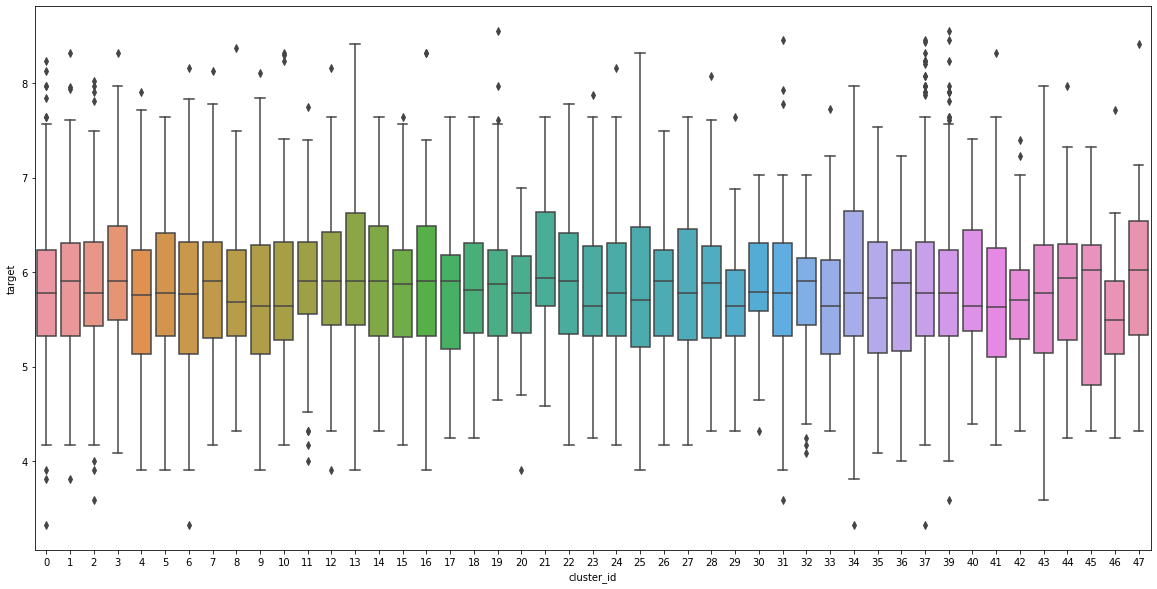

In [28]:
plt.figure(figsize=(20,10))
sns.boxplot(data = new_df[['cluster_id', 'target']], x='cluster_id', y='target')
#ax.set_ylim(10, 150)
plt.show()

In [29]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

mod = ols('target ~ cluster_id',
                data=new_df.query("cluster_id > 8 and cluster_id < 40")).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

                 sum_sq      df        F    PR(>F)
cluster_id     2.210901     1.0  3.55448  0.059469
Residual    2144.048147  3447.0      NaN       NaN


In [30]:
pred_df = new_df[['target'
    ,'cluster_id', 'distancefromcenter'
    ,'reviews_per_month', 'reviews_rating', 'reviews_num','booking_availability_30', 'booking_availability_60', 'booking_availability_90','booking_availability_365', 'property_bathrooms', 'booking_price_covers']]
host_dummies = pd.get_dummies(pred_df['cluster_id'], drop_first=True)
pred_df = pred_df.merge(host_dummies, left_index = True, right_index = True).drop(columns = 'cluster_id')
#.drop(columns = ['host_nr_listings_total', 'host_nr_listings', 'host_type'])


In [31]:
from sklearn.model_selection import train_test_split
target_variable = pred_df['target']
pred_df.drop(['target'], axis=1, inplace=True)
X = pred_df
train_data, test_data, train_target, test_target = train_test_split(X, target_variable, test_size=0.2)

In [32]:
# PREDICTION
# train_data, test_data, train_target, test_target
#from statistics import median as package_median

def rmse(predictions, targets):
    rmse_val = pow(sum(pow(predictions - targets, 2)) / len(targets), 0.5)
    return(rmse_val)

def medianABsoluteError(p, t):
    medae = np.abs(np.array(t) - np.array(p))
    return np.median(medae)

def meanAbsoluteError(p, t):
    medae = np.abs(np.array(t) - np.array(p))
    return medae.mean()

mean test:  0.7986871836369765
xgb test:  0.806736103861385
mean train:  0.7854694046891313
xgb train:  0.7355188121377702
MAE mean test:  0.49595749466241124
MAE xgb test:  0.5058261279226137
MAE mean train:  0.49595749466241124
MAE xgb train:  0.47846572684359234


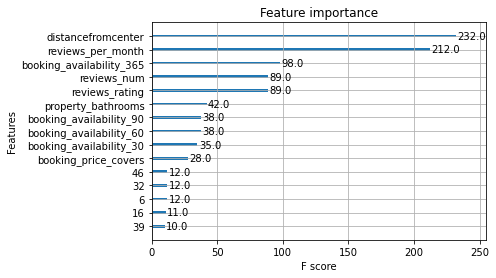

In [33]:
import xgboost
from xgboost import plot_importance
xgb = xgboost.XGBRegressor(eta=0.05, max_depth=15, subsample=0.7, gamma = 5)
xgb.fit(train_data, train_target)
xgb_preds_test = xgb.predict(test_data)
xgb_preds_train = xgb.predict(train_data)
print('mean test: ', rmse(train_target.mean(), test_target))
print('xgb test: ', rmse(xgb_preds_test, test_target))
print('mean train: ', rmse(train_target.mean(), train_target))
print('xgb train: ', rmse(xgb_preds_train, train_target))

print('MAE mean test: ', medianABsoluteError(train_target.median(), test_target))
print('MAE xgb test: ', medianABsoluteError(xgb_preds_test, test_target))
print('MAE mean train: ', medianABsoluteError(train_target.median(), train_target))
print('MAE xgb train: ', medianABsoluteError(xgb_preds_train, train_target))

plot_importance(xgb, max_num_features = 15)
plt.show()

ANTWERP

Eye checking top 20% and bottom 20% houses


In [34]:
xx = antwerp_df[['property_lat', 'property_lon', 'target']]
xx['top80'] = np.where(xx.target > antwerp_df.target.quantile(0.8), 1,0)
xx['bottom20'] = np.where(xx.target <= antwerp_df.target.quantile(0.2), 1,0)
xx = xx.query("top80 + bottom20 > 0")

/var/folders/36/jz61tnqj2nd6cp2y8_cvcdlh0000gn/T/ipykernel_42449/4040806098.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xx['top80'] = np.where(xx.target > antwerp_df.target.quantile(0.8), 1,0)
/var/folders/36/jz61tnqj2nd6cp2y8_cvcdlh0000gn/T/ipykernel_42449/4040806098.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xx['bottom20'] = np.where(xx.target <= antwerp_df.target.quantile(0.2), 1,0)


In [35]:
antwerp_map = folium.Map(location=[51.2312562,4.4223411], zoom_start=12)
folium.GeoJson(antwerp_geocodes, name="geojson").add_to(antwerp_map)

for i in list(range(2)):
    loop_df = xx.query(f"top80 == {i}")
    
    for j in range(0,loop_df.shape[0]):
        folium.Marker(
            location=[loop_df.iloc[j]['property_lat'], loop_df.iloc[j]['property_lon']],
            popup= str(loop_df.iloc[j]['target']),
            draggable=False
            , icon=folium.Icon(color=loop_colors[i])   
            ).add_to(antwerp_map)

antwerp_map

clustering iterations

playground

In [36]:
kms_per_radian = 6371.0088
radian_coordinates = np.radians(antwerp_df[['property_lat', 'property_lon']])
db = DBSCAN( eps = 0.25 / kms_per_radian
            , min_samples = 25
            , algorithm='ball_tree'
            , metric='haversine').fit(radian_coordinates)
print(pd.DataFrame(db.labels_).value_counts().sort_index())

antwerp_map = folium.Map(location=[51.2312562,4.4223411], zoom_start=12)
folium.GeoJson(antwerp_geocodes, name="geojson").add_to(antwerp_map)
db_scan_clusters = pd.concat([radian_coordinates.reset_index(),pd.DataFrame(db.labels_, columns=['cluster'])], axis=1)
#brux_loop = brussels_df.merge(db_scan_clusters, left_index=True, right_on='index')
db_clusters_filtered = db_scan_clusters
antwerp_loop = antwerp_df.merge(db_clusters_filtered, left_index=True, right_on='index')
antwerp_loop.set_index("index", inplace=True)

for i in list(antwerp_loop.cluster.unique()):
    loop_df = antwerp_loop.query(f"cluster == {i}")
    icon = folium.Icon(color=loop_colors[i])
    icone1 = folium.Icon(icon="asterisk", icon_color="#9b59b6", color="lightblue")
    
    for j in range(0,loop_df.shape[0]):
        folium.Marker(
            location=[loop_df.iloc[j]['property_lat_x'], loop_df.iloc[j]['property_lon_x']],
            popup= str(loop_df.iloc[j]['target']) + str(f"\n Cluster no: {i}"),
            draggable=False
            , icon=folium.Icon(color=loop_colors[i])   
            ).add_to(antwerp_map)

antwerp_map

-1    630
 0    240
 1     26
 2     45
 3     71
 4     34
 5     28
dtype: int64


In [37]:
kms_per_radian = 6371.0088
radian_coordinates = np.radians(antwerp_df[['property_lat', 'property_lon']])

df_list = []

eps_search = [0.25, 0.4]
samplesize_search = [25]

for eps in eps_search:
    for sample_size in samplesize_search:
        db = DBSCAN( eps = eps / kms_per_radian
                    , min_samples = sample_size
                    , algorithm='ball_tree'
                    , metric='haversine').fit(radian_coordinates)
        print('eps value: ',eps)
        print('samplesize value: ',sample_size)
        print(pd.DataFrame(db.labels_).value_counts().sort_index())

        db_scan_clusters = pd.concat([radian_coordinates.reset_index(),pd.DataFrame(db.labels_, columns=['cluster'])], axis=1)
        #brux_loop = brussels_df.merge(db_scan_clusters, left_index=True, right_on='index')
        cluster_sizes = db_scan_clusters.cluster.value_counts()
        filtered_clusters = cluster_sizes.loc[lambda x : (x > 60) & (x < 500)]
        out_df = db_scan_clusters[db_scan_clusters.cluster.isin(filtered_clusters.index)]
        df_list.append(out_df)
        print(out_df.shape)
        radian_coordinates = radian_coordinates.loc[~radian_coordinates.index.isin(out_df['index'])]
        print('------ \n')   

eps value:  0.25
samplesize value:  25
-1    630
 0    240
 1     26
 2     45
 3     71
 4     34
 5     28
dtype: int64
(311, 4)
------ 

eps value:  0.4
samplesize value:  25
-1    217
 0    483
 1     63
dtype: int64
(763, 4)
------ 



In [38]:
column_names = df_list[0].columns
cl_df = pd.DataFrame(columns = column_names)
for loop_nr, i in enumerate(df_list):
    cl_df = pd.concat([cl_df, i.assign(loop_id = loop_nr)], axis=0)

cl_df['cluster_id'] = cl_df.groupby(['loop_id','cluster']).ngroup()
cl_df.set_index('index', inplace=True)

antwerp_new_df = antwerp_df.merge(cl_df['cluster_id'], left_index=True, right_index=True)

Final clusters, green ones could be separated further actually... but didnt do it because having many clusters are not working either

In [39]:
antwerp_map = folium.Map(location=[51.2312562,4.4223411], zoom_start=12)
folium.GeoJson(antwerp_geocodes, name="geojson").add_to(antwerp_map)

for index,i in enumerate(list(antwerp_new_df.cluster_id.unique())):
    loop_df = antwerp_new_df.query(f"cluster_id == {i}")
    
    for j in range(0,loop_df.shape[0]):
        folium.Marker(
            location=[loop_df.iloc[j]['property_lat'], loop_df.iloc[j]['property_lon']],
            popup= str(loop_df.iloc[j]['target']) + str(f"\n Cluster no: {i}"),
            draggable=False
            , icon=folium.Icon(color=loop_colors[index])   
            ).add_to(antwerp_map)

antwerp_map

# aggregating results


In [42]:
output_df = pd.concat([new_df.assign(city = "Brussels"), antwerp_new_df.assign(city = "Antwerp")], axis=0, ignore_index=True)
output_df['cluster_id'] = output_df.groupby(['city', 'cluster_id']).ngroup()

In [45]:
#output_df[['property_id', 'property_lat', 'property_lon', 'city', 'cluster_id', 'distancefromcenter']].to_excel("cluster_results_df.xlsx", header=True, index=False)